In [14]:
import kagglehub
import pandas as pd
data = pd.read_csv("DATOS_L.csv")
data.columns


Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [15]:

X = data.drop(columns=["Bankrupt?"])
y = data["Bankrupt?"]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


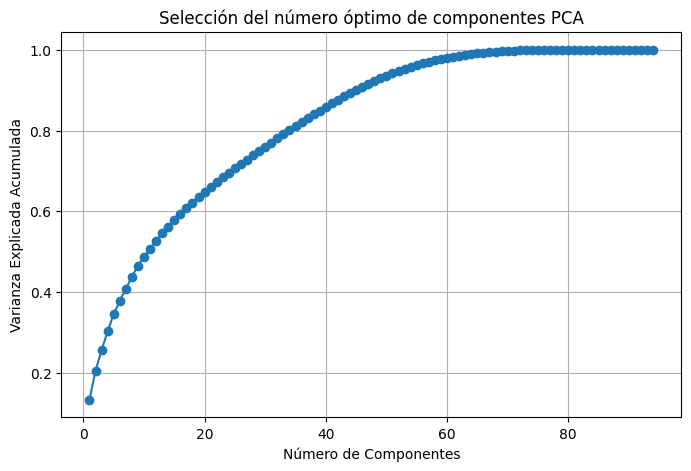

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Ajustamos PCA con todos los componentes
pca = PCA()
pca.fit(X_scaled)

# Varianza acumulada
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Gráfica de varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Selección del número óptimo de componentes PCA')
plt.grid(True)
plt.show()


In [ ]:
# Ajustar PCA sin reducir aún
pca = PCA()
pca.fit(X_scaled)

# Calcular varianza acumulada
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Elegir el número de componentes que expliquen al menos el 95% de la varianza
n_components_95 = np.argmax(explained_var >= 0.95) + 1  # +1 porque los índices empiezan en 0

print(f"Número óptimo de componentes para explicar el 95% de la varianza: {n_components_95}")


Número óptimo de componentes para explicar el 95% de la varianza: 53


In [19]:
pca = PCA(n_components=53)
X_pca = pca.fit_transform(X_scaled)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 0.03002115752055512
R²: 0.16589394916054068


EVALUATING. 

Esta parte debería también ir incluida en score.py

In [21]:
import numpy as np

def sigmoid(x):
    return [1 / (1 + np.exp(-y)) for y in x]

y_pred = sigmoid(y_pred)

y_pred_sort = {i:y_pred[i] for i in range(len(y_pred))}
y_pred_sort = dict(sorted(y_pred_sort.items(), key=lambda x: x[1], reverse=True))

how_many_ones = y_test.value_counts()[1]

one_predictions = list(y_pred_sort.keys())[:how_many_ones]

final_preds = [1 if x in one_predictions else 0 for x in range(len(y_pred))]

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1313
           1       0.33      0.33      0.33        51

    accuracy                           0.95      1364
   macro avg       0.65      0.65      0.65      1364
weighted avg       0.95      0.95      0.95      1364



In [23]:
umbral = min([y_pred_sort[x] for x in one_predictions])

print(f"CÓMO PREDECIR CON ESTE MODELO:\n\n Paso 1.- Calcularlo con la regresión lineal.\n PASO 2.- Aplicarle sigmoide para acotarlo al intervalo [0,1].\n PASO 3.- Si el resultado es mayor a {umbral} entonces predecir 1.\n          De lo contrario, predecir 0.")


import json

umb = json.dumps({"umbral": [umbral]})
file = open("umbral.json", "w")
file.write(umb)
file.close()

import pickle

file = open('model.pkl', 'wb')
pickle.dump(model, file)
file.close()

CÓMO PREDECIR CON ESTE MODELO:

 Paso 1.- Calcularlo con la regresión lineal.
 PASO 2.- Aplicarle sigmoide para acotarlo al intervalo [0,1].
 PASO 3.- Si el resultado es mayor a 0.5394936794490179 entonces predecir 1.
          De lo contrario, predecir 0.


In [31]:
# Crear csv para probar modelo
rand_rows = [23, 300, 278, 120, 800]
testcsv = pd.DataFrame(X_test).iloc[rand_rows, :]
testcsv

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
23,1.128663,-1.595254,0.858068,-1.941674,0.164878,0.237919,0.514694,-0.327606,-0.082105,-0.993985,...,-0.789815,-0.340522,0.108396,-0.261017,0.244645,0.357488,0.345566,-0.397126,0.751604,-0.613768
300,-1.690968,-1.575963,-0.456906,-0.601297,-0.112064,-0.322132,-1.231575,1.180397,-1.209120,-0.307961,...,-0.593923,-0.323844,0.101308,-0.170111,-0.358602,-0.112397,-0.174378,1.024474,-1.123804,-0.360140
278,-3.413149,0.496334,1.623365,2.327541,-0.681955,2.068346,0.285685,-1.332325,0.069928,0.205970,...,0.279354,-0.849530,-0.672272,-0.076523,-0.235850,-0.168099,0.018724,0.704721,-0.478856,0.464973
120,-2.475455,-1.355050,2.578546,2.785472,-0.884563,0.191082,0.168952,-0.687776,0.103172,0.089444,...,-0.378602,0.259648,-0.308975,0.070118,-0.149564,-0.086378,-0.034182,0.680112,-0.475525,0.031812
800,1.045206,0.809215,1.184283,1.888430,-0.321348,1.106399,0.643379,-1.156735,0.705574,0.908514,...,-1.200772,-1.378945,-1.127354,-0.797889,-0.115947,-0.066175,0.293434,0.272591,0.032325,0.476915


In [32]:
testcsv.to_csv('testapi.csv', index=False)

In [33]:
model = pickle.load(open('model.pkl','rb'))
df_testAPI = pd.read_csv('testapi.csv')
pred = model.predict(df_testAPI)
pred

c:\Users\Iván Ortiz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([-0.02865607,  0.01397103,  0.11942301,  0.05073338,  0.06947542])